># ***A Extensive data analysis on Novel Coronavirus***

## **Import libraries**

In [2]:
## importing necessary libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import scipy.stats as st
import os, re, requests, bs4, warnings
from tqdm import tqdm
import numpy as np
from matplotlib import ticker as mtick
from matplotlib import dates as mdate
from datetime import datetime as dt
from matplotlib.patches import FancyBboxPatch
import cmasher as cmr
warnings.filterwarnings('ignore')
sns.set_style('white')

## setting up some parameters for making a clean and sound data visualization:
from matplotlib import rcParams
rcParams['figure.figsize']= (10.5,5)
rcParams['axes.linewidth']=0.3
rcParams['axes.labelsize']=15
rcParams['axes.labelweight']='semibold'
rcParams['axes.titlesize']=16
rcParams['axes.titleweight']='semibold'
rcParams['axes.edgecolor']='grey'
rcParams['font.stretch']='semi-condensed'
rcParams['font.family']='Arial'
rcParams['legend.frameon']=False
rcParams['legend.fontsize']=10.5
rcParams['ytick.labelsize']=12.5
rcParams['xtick.labelsize']=12.5
rcParams['axes.spines.top']=False
rcParams['axes.spines.right']=False
rcParams['grid.linestyle']='--'
rcParams['grid.color']='grey'
rcParams['grid.alpha']= 0.3
rcParams['axes.titlelocation']='left'

### Important functions

In [3]:
# Function for min-max scaling or normalizing values from 0 to 1.
def min_max(x):
    return [(i-x.min())/(x.max()-x.min()) for i in x]

In [4]:
# Function to get sequential color hex codes
def get_color_codes(name, size):
  from cmasher import take_cmap_colors
  return take_cmap_colors(name, size, return_fmt='hex')

In [5]:
# Function for extracting tables from Wikipedia
def extract_html_table(url, which= 0, columns=None):
    html= requests.get(url)
    soup= bs4.BeautifulSoup(html.content)
    body= soup.find_all('table',{'class':'wikitable'})[which].find('tbody')
    rows= [[i.text.strip('\n').strip() for i in row.find_all(['th','td'])] for row in body.find_all('tr')]
    cols= rows.pop(0)
    if columns is not None:
        return pd.DataFrame(rows, columns= cols)[columns]
    else:
        return pd.DataFrame(rows, columns= cols)

In [6]:
# Function for formatting large numbers in abbreviated format 
def format_numbers(number, pos=None, fmt= '.0f'):
    fmt= '%'+fmt
    thousands, millions, bilions= 1_000, 1_000_000, 1_000_000_000
    if number/bilions >=1:
        return (fmt+'B') %(number/bilions)
    elif number/millions >=1:
        return (fmt+'M') %(number/millions)
    elif number/thousands >=1:
        return (fmt+'K') %(number/thousands)
    else:
        return fmt %(number)

In [7]:
# Function to map HDI score of countries to HDI Group.
def map_hdi(x):
    '''HDI is divided into four tiers: very high human development (0.8-1.0), high human development (0.7-0.79), medium human development (0.55-. 70), and low human development (below 0.55).'''
    if (x >=0.8):
        return 'Very High'
    elif (x < 0.8) & (x>=0.7):
        return 'High'
    elif (x<0.7) & (x >=0.55):
        return 'Medium'
    else: 
        return 'Low'

## **Get data**
- Get daily time series data for covid cases and deaths provided by.
- Get population data of the desired countries.
- Get Human Development Index data of the desired countries from wikipedia.
- Get data for continents.

In [8]:
# Load data
data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv') # daily time series data for covid cases and deaths
world_pop= pd.read_csv('world_pop.csv',usecols= ['Location','Time','PopTotal']) # Population data
hdi= pd.read_html('https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index')[0].reset_index() # Human Development Index data
cont= pd.read_csv('csvData.csv')
# Brief look
data.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


In [10]:
# Get info
print('Data dimensions:')
print('No of rows: {}, No of columns: {}'.format(format_numbers(data.shape[0], fmt='0.1f'), data.shape[1]))
print('--'*20)
data.info(verbose=False)

Data dimensions:
No of rows: 222.5K, No of columns: 8
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222543 entries, 0 to 222542
Columns: 8 entries, Date_reported to Cumulative_deaths
dtypes: int64(4), object(4)
memory usage: 13.6+ MB


## **Data preparation and cleaning**
#### **Population data**
1. *To clean the data and rename the required columns.*
2. *To merge the data with covid-19 data.*

#### **Covid-19 data**
1. *To keep the required columns and rename them.*
2. *To parse Report Date to datetime dtype*
3. *To drop countries having 0 cases and deaths.*
4. *To rename country names*

#### **Human Developnment Index data**
1. *To keep only required columns and rename the column names.*
2. *To create a new feature 'HDI category' and parse as Categorical datatype.*
3. *To rename country names*
4. *To merge the data with covid-19 data.*

#### **Continents Data**
1. *To Rename country names*
2. *To merge Continents to df after renaming the other country names.*
3. *To calculate spread in cases and deaths before filtering the dataset from year 2021.*
4. *To Slice the dataset from year 2021.*

In [11]:
# Data cleaning in World population data
world_pop= world_pop[world_pop.Time == 2021] # Filter data from year 2021
world_pop= (world_pop.groupby('Location').PopTotal.mean()*1000).reset_index() # Group the data and convert population to billions. 
world_pop.columns= ['country','popul'] # Renaming columns
# Rename countries
world_pop.country= world_pop.country.replace({'United Kingdom' :'The United Kingdom',
                                              'Turkey':'Türkiye',
                                              'Vietnam':'Viet Nam'})

In [12]:
# Rename countries in df to merge with continents data
renaming_countries_df= {  'Falkland Islands (Malvinas)': 'Falkland Islands',
                            'Réunion': 'Reunion',
                            'Syrian Arab Republic': 'Syria',
                            'Iran (Islamic Republic of)': 'Iran',
                            'Republic of Korea': 'South Korea',
                            'Venezuela (Bolivarian Republic of)': 'Venezuela',
                            'United Republic of Tanzania': 'Tanzania',
                            'Democratic Republic of the Congo': 'Congo',
                            'Russian Federation': 'Russia',
                            'United States of America': 'United States',
                            'Northern Mariana Islands (Commonwealth of the)': 'Northern Mariana Islands',
                            'Micronesia (Federated States of)': 'Micronesia',
                            'Bolivia (Plurinational State of)': 'Bolivia',
                            'Republic of Moldova': 'Moldova',
                            'Brunei Darussalam': 'Brunei',
                            'Cabo Verde': 'Cape Verde' ,
                            'The United Kingdom': 'United Kingdom',
                            'Türkiye':'Turkey',
                            'Samoa':'American Samoa',
                            'Viet Nam':'Vietnam'}

In [13]:
# Renaming  column names
cols_to_keep= ['Date_reported','Country','New_cases','Cumulative_cases','New_deaths','Cumulative_deaths']
df= data[cols_to_keep]
# Lower casing column names:
df.columns= ['date','country','new_cases','total_cases','new_deaths','total_deaths']
# Parse date to datetime
df.date= pd.to_datetime(df.date)

# Drop rows having countries with total positive cases = 0
countries_to_drop= df.groupby('country').total_cases.sum()[df.groupby('country').total_cases.sum()==0].index.to_list()
rows_to_drop= df[df.country.isin(countries_to_drop)].index
df= df.drop(rows_to_drop, axis=0)

# Rename countries
df.country= df.country.replace(renaming_countries_df)

# Merge df with world population dataframe
df= pd.merge(df, world_pop, on='country', how='left')

In [14]:
# Data cleaning in HDI data
hdi= hdi.iloc[:,3:5] # keep only 'country' and 'HDI' features
hdi.columns= ['country', 'hdi'] # Renaming columns
hdi['hdi_category']= hdi.hdi.apply(map_hdi) # Engineer new feature using HDI

# converting HDI category to categorical datatype
cat_dtype= pd.CategoricalDtype(categories=['Low','Medium','High','Very High'], ordered=True)
hdi.hdi_category= hdi.hdi_category.astype(cat_dtype)

hdi.country= hdi.country.replace({'Samoa':'American Samoa','Democratic Republic of the Congo':'Congo'})
df= pd.merge(df, hdi, on='country', how='left') # Merge hdi with data

In [15]:
# Data cleaning in Continents data
cont.country= cont.country.replace({'DR Congo':'Congo'})
# Merge to df
df= pd.merge(df, cont, on='country',how='left')

In [16]:
cases_spread_overtime= (df.groupby('date').apply(lambda x: x.country[x.total_cases >=1].nunique())/df.country.nunique())[:'2020-06-01']
deaths_spread_overtime= (df.groupby('date').apply(lambda x: x.country[x.total_deaths >=1].nunique())/df.country.nunique())[:'2020-06-01']
df= df[df.date >= '2021-01-01']

## **EDA**
1. *To get date range of the time series data.*
2. *To visualize global trends.*
3. *To plot percentage changes in weekly cases and deaths*
4. *To display countries and continents based on positive cases and deaths.* 
5. *To show how daily cases and deaths are distrinuted.*
6. *To show top most affected countries in death rate and overall positivity.*
7. *To plot weekly trends in top 5 most affected countries.*
8. *To calculate spread of the disease in various countries over time.*
9. *To compare death rates and affected ratio of population with Human developnment index of lsited countries.*
10. *To plot pie-chart showing most affected countries in with their share of total world population .*

In [17]:
# Get overall daily count of total deaths from covid-19 
grped_total= df.groupby('date')['total_cases','total_deaths'].sum().rename({'total_cases':'cases', 'total_deaths':'deaths'}, axis=1)
# Get overall daily count of new deaths from covid-19 
grped_new= df.groupby('date')['new_cases','new_deaths'].sum().rename({'new_cases':'cases', 'new_deaths':'deaths'}, axis=1)
# Get overall weekly count of new deaths from covid-19 
weekly= grped_new.resample('W').sum()
# Get percent change in weekly cases and deaths
percent_change= weekly.pct_change(periods= 3).dropna()
# Parse the index of above grouped data to datetime.
for date in [grped_total, grped_new, weekly, percent_change]:
    date.index= date.index.astype(str)
    date.index= pd.to_datetime(date.index)

In [18]:
# Get metrics
max_date= grped_total.index[-1].strftime('%d %B, %Y')
max_cases= format_numbers(grped_total.cases.values[-1], fmt='.0f')
max_deaths= format_numbers(grped_total.deaths.values[-1], fmt='.1f')
reports= f'As of {max_date}, there has been a total of {max_cases} positive cases and {max_deaths} deaths from covid-19 pandemic worldwide.\n\n'

This Data ranges from 01 Jan, 2021 to 29 Jul, 2022


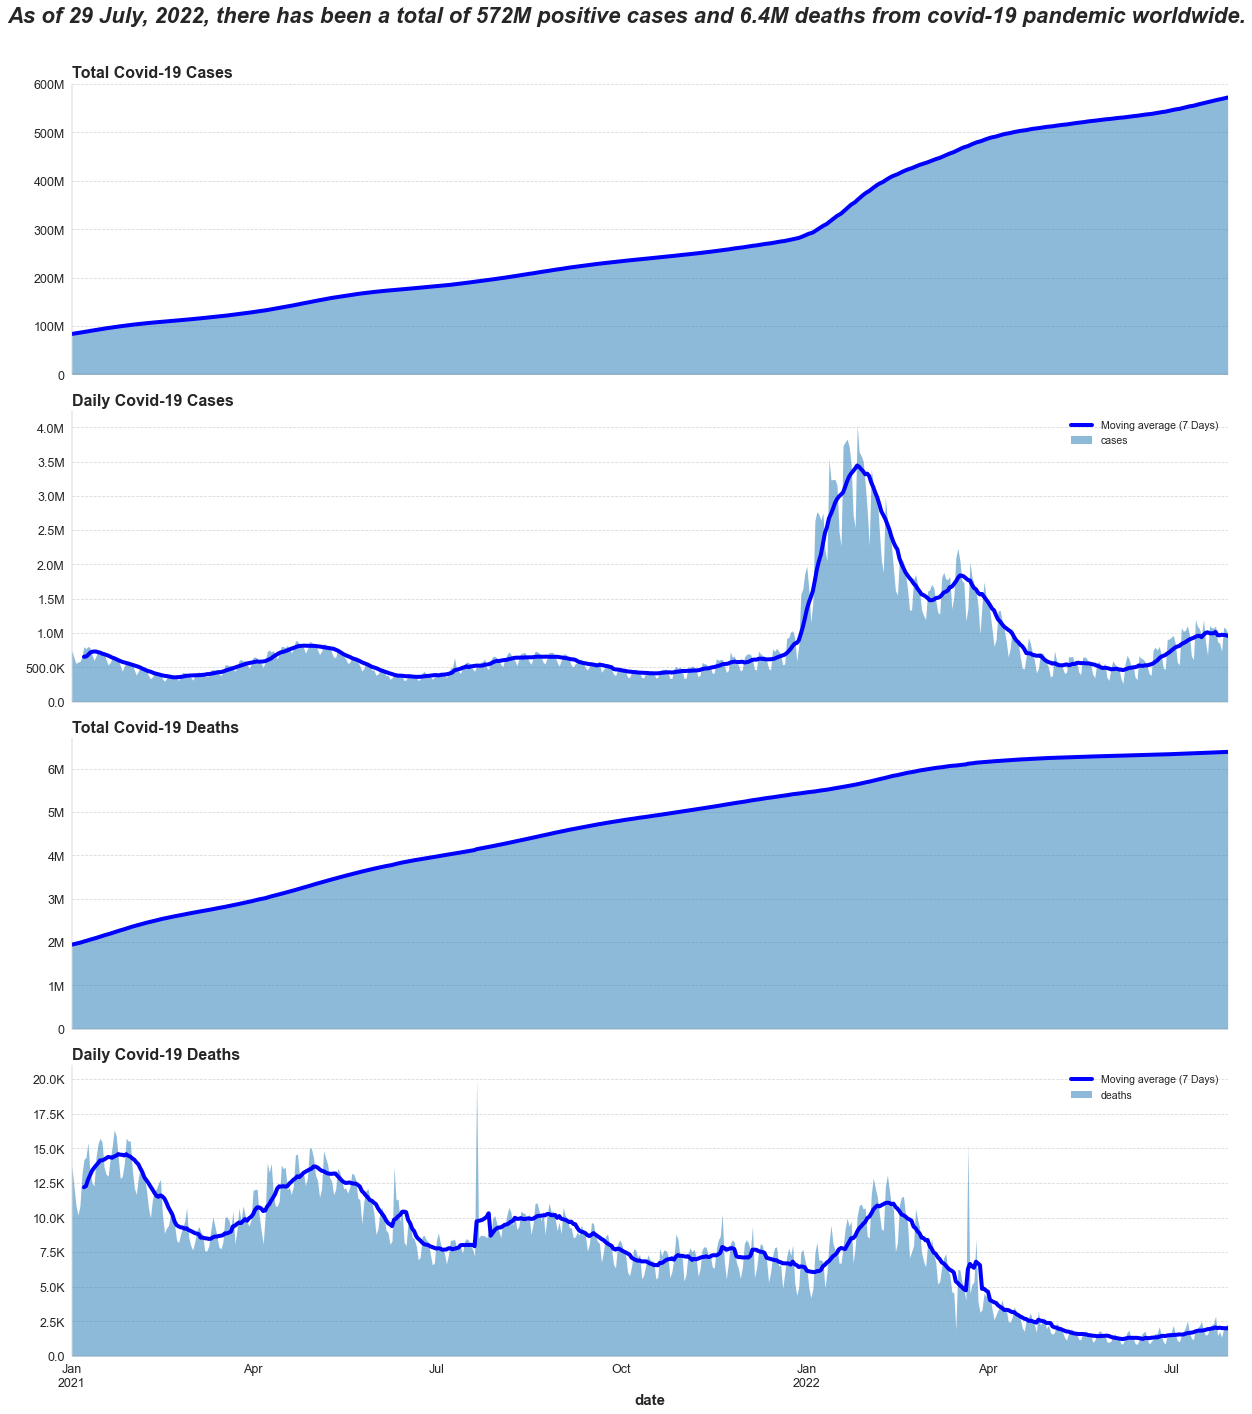

In [19]:
# Daily and cumulative trends in positive cases and deaths

# Print the date ranges for the time-series data
print(f'This Data ranges from {df.date.min():%d %b, %Y} to {df.date.max():%d %b, %Y}')

fig, (ax1,ax2, ax3,ax4)= plt.subplots(4,1, figsize= (17,20), sharex=True)
grped_total.cases.plot(kind='area', alpha=0.5, lw=0, ax=ax1)
grped_total.cases.plot(lw=4, color='blue', ax= ax1)
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,pos: format_numbers(x)))
ax1.set_title('Total Covid-19 Cases')
ax1.grid(axis='y')

# plot new confirmed cases along with moving average for 7 days
grped_new.cases.plot(kind='area', alpha=0.5, lw=0, ax=ax2)
grped_new.cases.rolling(7).mean().plot(lw=4, color='blue', ax=ax2, label='Moving average (7 Days)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,pos: format_numbers(x, fmt='.1f')))
ax2.set_title('Daily Covid-19 Cases')
ax2.legend()
ax2.grid(axis='y')

# plot total confirmed deaths
grped_total.deaths.plot(kind='area', alpha=0.5, lw=0, ax=ax3)
grped_total.deaths.plot(lw=4, color='blue', ax= ax3)
ax3.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,pos: format_numbers(x)))
ax3.set_title('Total Covid-19 Deaths')
ax3.grid(axis='y')

# plot new confirmed deaths along with moving average for 7 days
grped_new.deaths.plot(kind='area', alpha=0.5, lw=0, ax=ax4)
grped_new.deaths.rolling(7).mean().plot(lw=4, color='blue', ax=ax4, label='Moving average (7 Days)')
ax4.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,pos: format_numbers(x, fmt='.1f')))
ax4.set_title('Daily Covid-19 Deaths')
ax4.grid(axis='y')
ax4.legend()
fig.suptitle(reports, size= 22, style='italic', weight='bold')
plt.tight_layout()
plt.show()

- Out of total 545M positive cases, 6.3M people have been succumbed to death due to Covid-19 pandemic, which is approximately 1% of the overall positivity.
- There hasn't been any significant increase in new positive cases in year 2021.
- Contrary to the postive cases, there hasn't been any change in increase in deaths in 2021.
- While, in the beginning of 2022, positive cases and deaths started rising again, but, eventually, deaths slumped down to lowest since 2021 and positive cases decreased to 750K cases per day.

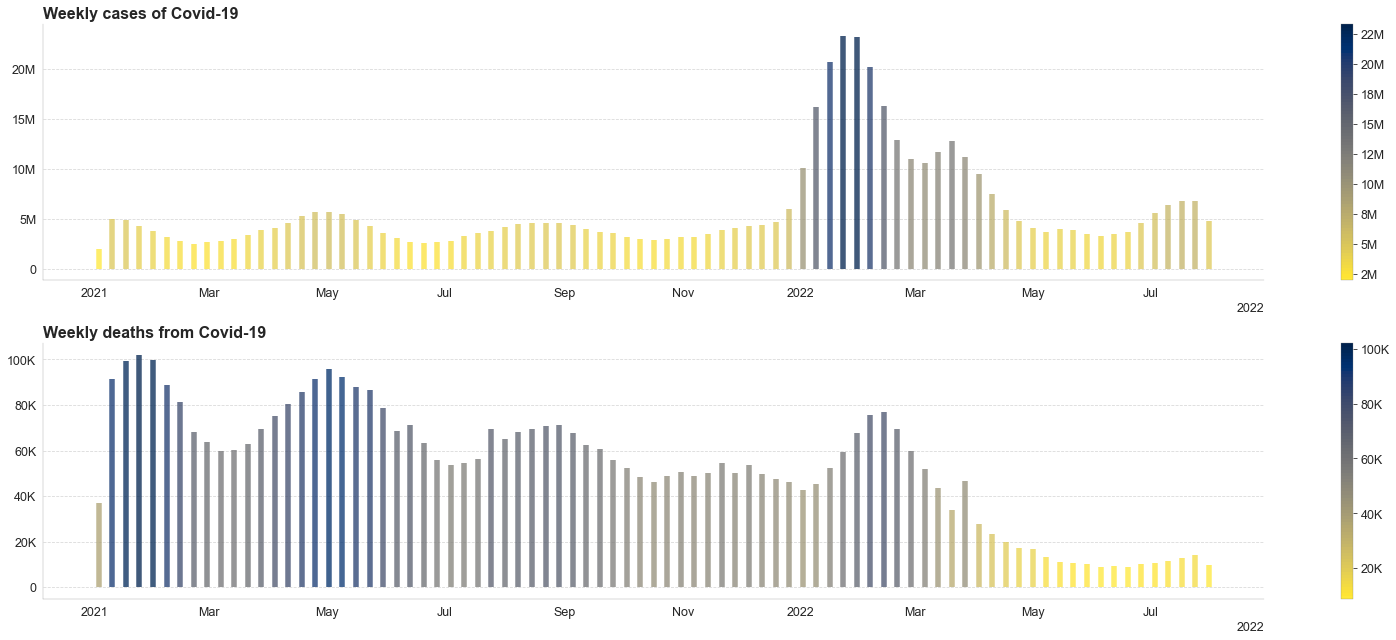

In [20]:
# Weekly trends of new cases and deaths worldwide. 
fig,ax= plt.subplots(2,1,figsize= (22,9))
# get custom colormaps
colors= plt.get_cmap('cividis_r',len(weekly))

ax[0].grid(axis='y')
ax[0].xaxis.set_major_formatter(mdate.DateFormatter('%b %Y'))
ax[0].xaxis.set_major_formatter(mdate.ConciseDateFormatter(ax[0].xaxis.get_major_locator()))
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,pos: format_numbers(x)))
ax[0].vlines(x=weekly.index, ymin=0, ymax=weekly.cases,lw=5.5, alpha=0.75, colors= colors(min_max(weekly.cases)))
ax[0].set_title('Weekly cases of Covid-19')
# format Colorbar ticks
vmin, vmax= weekly.cases.min(), weekly.cases.max()
norm= plt.Normalize(vmin=vmin, vmax= vmax)
sm= plt.cm.ScalarMappable(cmap=colors, norm=norm)
cbar= plt.colorbar(mappable=sm, ax= ax[0])
cbar.formatter.axis.set_major_formatter(format_numbers)

ax[1].grid(axis='y')
ax[1].xaxis.set_major_formatter(mdate.DateFormatter('%b %Y'))
ax[1].xaxis.set_major_formatter(mdate.ConciseDateFormatter(ax[1].xaxis.get_major_locator()))
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,pos: format_numbers(x)))
ax[1].vlines(x=weekly.index, ymin=0, ymax=weekly.deaths, lw=5.5,alpha=0.75, colors= colors(min_max(weekly.deaths)))
ax[1].set_title('Weekly deaths from Covid-19')
vmin, vmax= weekly.deaths.min(), weekly.deaths.max()
norm= plt.Normalize(vmin=vmin, vmax= vmax)
sm= plt.cm.ScalarMappable(cmap=colors, norm=norm)
cbar= plt.colorbar(mappable=sm, ax= ax[1])
cbar.formatter.axis.set_major_formatter(format_numbers)

plt.tight_layout()

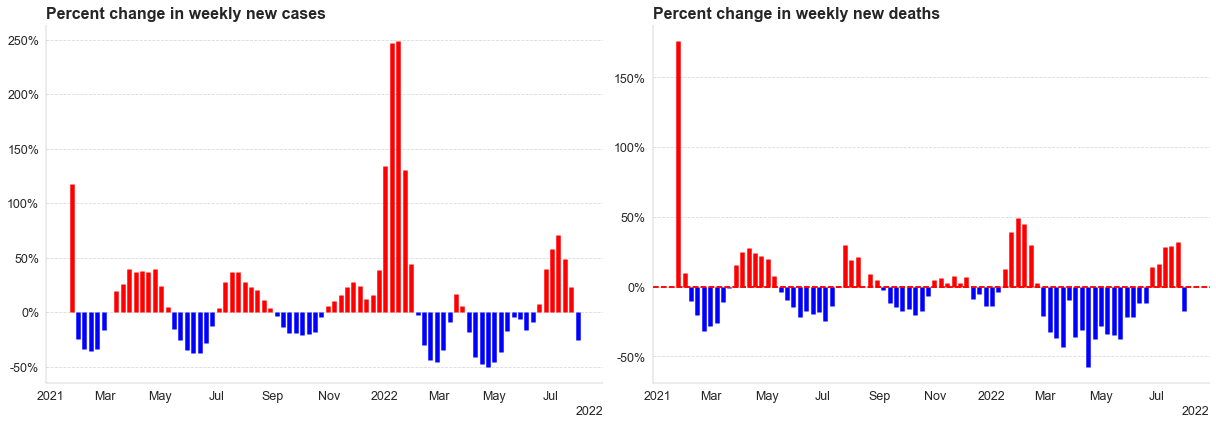

     cases deaths
mean   11%    -3%
std    53%    30%
min   -50%   -57%
25%   -20%   -20%
50%     3%    -9%
75%    27%    10%
max   249%   176%


In [21]:
# Percent change in weekly positive cases and deaths
fig,(ax1,ax2) = plt.subplots(1, 2, figsize= (17,6))
colors= ['red' if i> 0 else 'blue' for i in percent_change.deaths]
ax2.xaxis.set_major_formatter(mdate.DateFormatter('%b%Y'))
ax2.xaxis.set_major_formatter(mdate.ConciseDateFormatter(ax2.xaxis.get_major_locator()))
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))
ax2.vlines(x=percent_change.index, ymin=0, ymax= percent_change.deaths, lw=4.5, colors= colors)
plt.axhline(ls='--', lw=1.5, color='red')
ax2.set_title('Percent change in weekly new deaths')
ax2.grid(axis='y')

colors= ['red' if i> 0 else 'blue' for i in percent_change.cases]
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%b%Y'))
ax1.xaxis.set_major_formatter(mdate.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))
ax1.vlines(x=percent_change.index, ymin=0, ymax= percent_change.cases, lw=4.5, colors= colors)
plt.axhline(ls='--', lw=1.5, color='red')
ax1.set_title('Percent change in weekly new cases')
ax1.grid(axis='y')

plt.tight_layout()
plt.show()
print(percent_change.describe().loc['mean':,].applymap('{:.0%}'.format))

- Average percent change in weekly cases and deaths are 9% and -5% respectively.
- There are lot of variations in change in cases and deaths.
- For 25% of the time, % change in cases and deaths have been more than 24% and 7% respectively.
- Both, positive cases and deaths have increased by 2 times

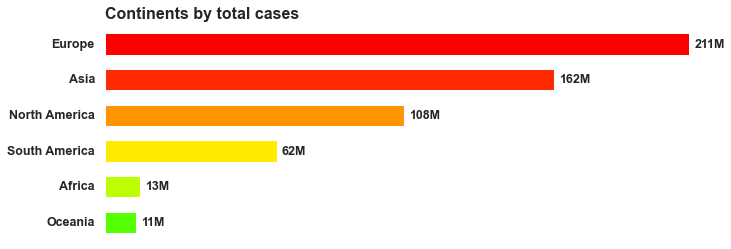

In [22]:
# continents by total positive cases
grped_cont= df[df.date== df.date.max()].groupby('continent')['total_cases','total_deaths'].sum()
ax= grped_cont.total_cases.sort_values().plot(kind='barh', width=0.6, color= get_color_codes('prism_r',6), figsize= (11,4))
ax.set_title('Continents by total cases')
for rect, label in zip(ax.patches, ax.get_yticklabels()):
    xy= (rect.get_width()+rect.get_x()/2, rect.get_y())
    plt.annotate(xy= xy, text= format_numbers(rect.get_width()), size= 12.5,
                weight='bold', textcoords= 'offset points', xytext= (5,8), ha='left')
    xy= (rect.get_x(), rect.get_y())
    plt.annotate(xy=xy, text= label.get_text(), textcoords= 'offset points', xytext= (-10,8), ha='right', size= 12.5, weight='bold')
ax.set_axis_off()

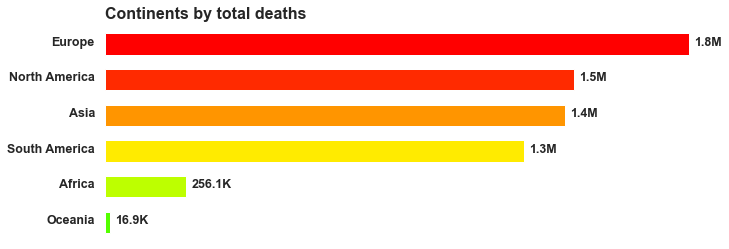

In [23]:
# Continents bt total deaths
ax= grped_cont.total_deaths.sort_values().plot(kind='barh', width=0.6, color= get_color_codes('prism_r',6), figsize= (11,4))
ax.set_title('Continents by total deaths')
for rect, label in zip(ax.patches, ax.get_yticklabels()):
    xy= (rect.get_width()+rect.get_x()/2, rect.get_y())
    plt.annotate(xy= xy, text= format_numbers(rect.get_width(), fmt='.1f'), size= 12.5,
                weight='bold', textcoords= 'offset points', xytext= (5,10), ha='left')
    xy= (rect.get_x(), rect.get_y())
    plt.annotate(xy=xy, text= label.get_text(), textcoords= 'offset points', xytext= (-10,10), ha='right', size= 12.5, weight='bold')
ax.set_axis_off()

- Europe is the most affected continent from Coronavirus, with 200M total cases and around 1.8 millions deaths.
- North America has less confirmed cases but more confirmed deaths than Asia.
- Oceania and Africa are the least affected continents by Covid-19 in terms of number of cases and deaths

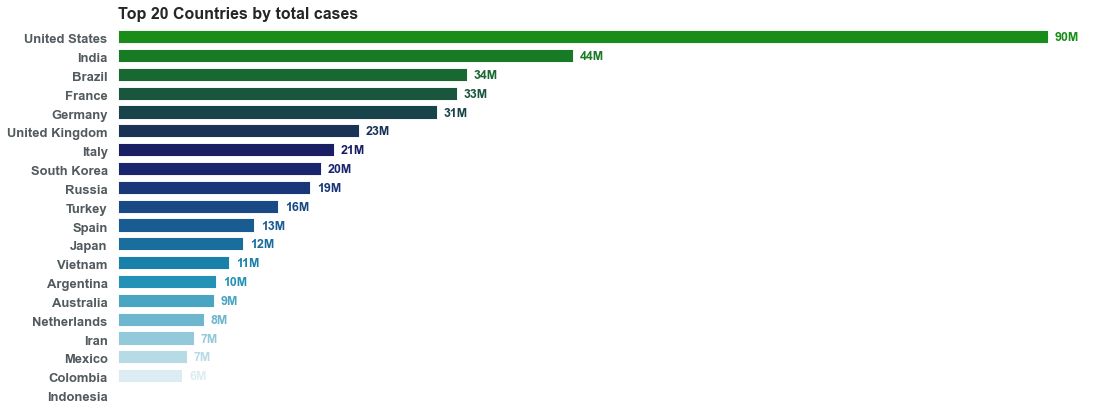

In [24]:
# list top 20 countries in total cases
grped_countries= df.groupby('country')['total_cases','total_deaths'].max()
ax= grped_countries.total_cases.sort_values()[-20:].plot(kind='barh', width=.7,color= get_color_codes('ocean_r',20),alpha=0.9, figsize= (17.5,7))
ax.set_title('Top 20 Countries by total cases')
for rect, label in zip(ax.patches, ax.get_yticklabels()):
    xy= (rect.get_width()+rect.get_x()/2, rect.get_y())
    plt.annotate(xy= xy, text= format_numbers(rect.get_width()), size= 12.5,
                weight='bold', textcoords= 'offset points', xytext= (7,2), ha='left', color= rect.get_facecolor())
    xy= (rect.get_x(), rect.get_y())
    plt.annotate(xy=xy, text= label.get_text(), textcoords= 'offset points', xytext= (-10,0), ha='right', size= 13, weight='bold', color='#525a5e')
ax.set_axis_off()

As of July, 2022, United states is having highest count in total positive cases of Covid-19 followed by India and Brazil, with 86M, 44M and 30M confirmed positive cases respectively.

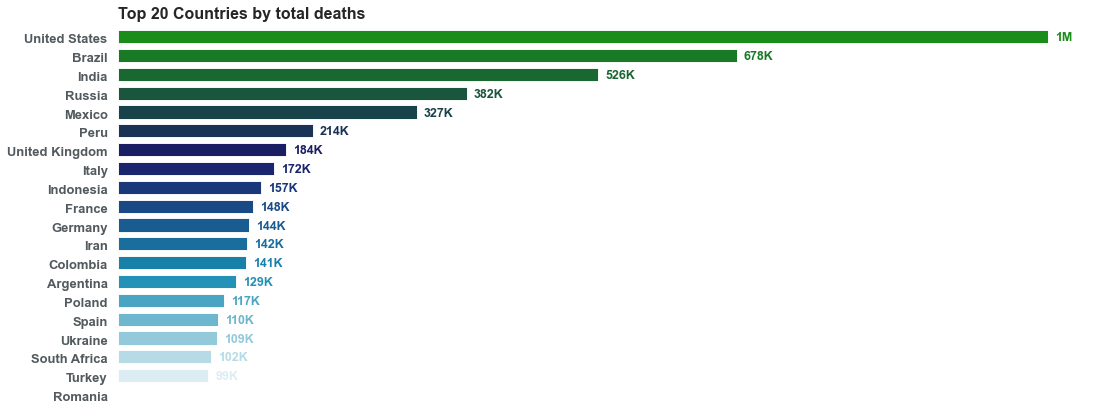

In [25]:
# list top 20 countries in total deaths
grped_countries= df.groupby('country')['total_cases','total_deaths'].max()
ax= grped_countries.total_deaths.sort_values()[-20:].plot(kind='barh', width=.7,color= get_color_codes('ocean_r',20),alpha=0.9, figsize= (17.5,7))
ax.set_title('Top 20 Countries by total deaths')
for rect, label in zip(ax.patches, ax.get_yticklabels()):
    xy= (rect.get_width()+rect.get_x()/2, rect.get_y())
    plt.annotate(xy= xy, text= format_numbers(rect.get_width()), size= 12.5,
                weight='bold', textcoords= 'offset points', xytext= (7,2), ha='left', color= rect.get_facecolor())
    xy= (rect.get_x(), rect.get_y())
    plt.annotate(xy=xy, text= label.get_text(), textcoords= 'offset points', xytext= (-10,0), ha='right', size= 13, weight='bold',color= '#525a5e')
ax.set_axis_off()

As of July, 2022, United states is having highest count in total confirmed deaths from Covid-19 followed by Brazil and India, with 1M,671K and 525K total deaths respectively.

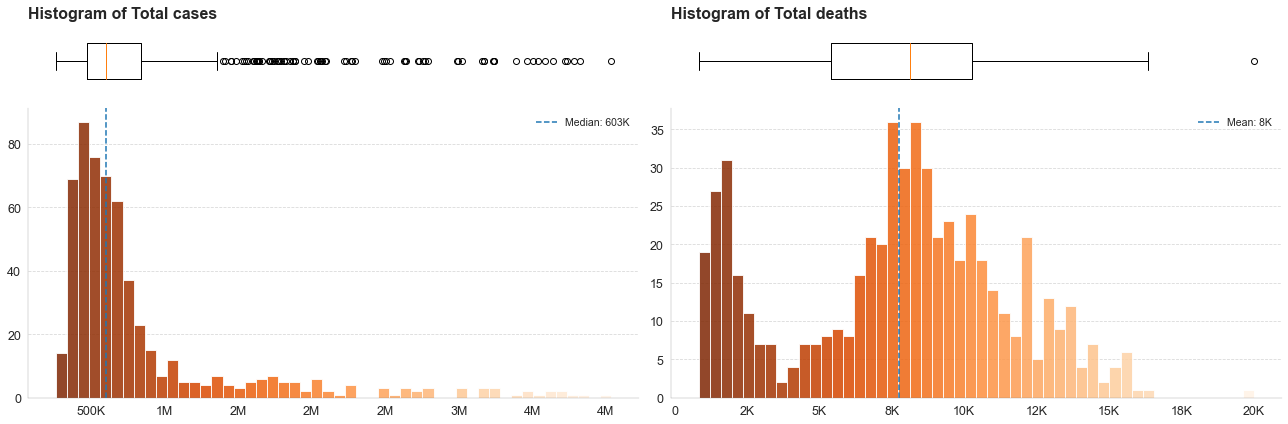

In [26]:
# Distribution of daily cases and deaths
fig, ax= plt.subplots(2,2, figsize= (18,6), gridspec_kw={'height_ratios': (0.2,0.8)})
n, bins, patches= ax[1, 0].hist(grped_new.cases, bins=50, alpha=0.85)
ax[1,0].axvline(grped_new.cases.median(),ls='--',label='Median: {}'.format(format_numbers(grped_new.cases.median())))
cmap= plt.cm.get_cmap('Oranges_r')
for rect,c in zip(patches, cmap(min_max(bins))):
    rect.set_facecolor(c)
norm= plt.Normalize(vmin= min(bins), vmax= max(bins))
sm= plt.cm.ScalarMappable(norm= norm, cmap= cmap)
ax[1,0].xaxis.set_major_formatter(mtick.FuncFormatter(format_numbers))
ax[1,0].grid(axis='y')
ax[1,0].legend()
# cbar= plt.colorbar(mappable=sm, ax=ax[1,0])
# cbar.formatter.axis.set_major_formatter(mtick.FuncFormatter(format_numbers))

n, bins, patches= ax[1,1].hist(grped_new.deaths, bins=50, alpha=0.85)
ax[1,1].axvline(grped_new.deaths.mean(), ls='--',label='Mean: {}'.format(format_numbers(grped_new.deaths.mean())))
cmap= plt.cm.get_cmap('Oranges_r')
for rect,c in zip(patches, cmap(min_max(bins))):
    rect.set_facecolor(c)
norm= plt.Normalize(vmin= min(bins), vmax= max(bins))
sm= plt.cm.ScalarMappable(norm= norm, cmap= cmap)
ax[1,1].xaxis.set_major_formatter(mtick.FuncFormatter(format_numbers))
ax[1,1].grid(axis='y')
ax[1,1].legend()
# cbar= plt.colorbar(mappable=sm, ax= ax[1,1])
# cbar.formatter.axis.set_major_formatter(mtick.FuncFormatter(format_numbers))

ax[0,0].set(**{'title':'Histogram of Total cases','xlabel':'Total cases'})
ax[0,1].set(**{'title':'Histogram of Total deaths','xlabel':'Total deaths'})
ax[0,0].boxplot(grped_new.cases, vert=False,widths= 0.5)
ax[0,1].boxplot(grped_new.deaths, vert=False,widths= 0.5)
ax[0,0].set_axis_off()
ax[0,1].set_axis_off()

plt.tight_layout()

- New cases follows a positively skewed distribution, implying that there are lot of variations with daily positive cases.
- While, new deaths follow a gaussian like distrubution (symmetric distribution), indicating that, most of the daily deaths from Covid-19 were near the average.

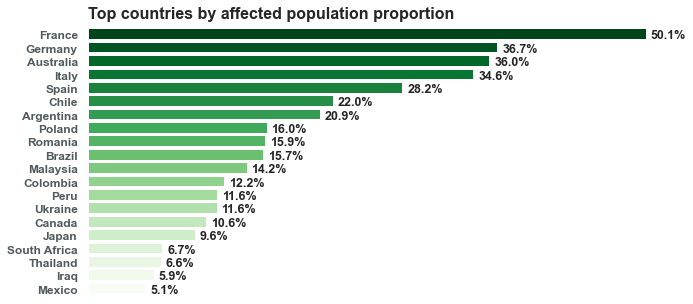

In [27]:
# List down top 20 countries in total affected proportion from the disease.
countries_with_top_pop= world_pop[world_pop.country.isin(df.country)].sort_values(by='popul')[-50:].country.to_list()
prop_affected= df[df.country.isin(countries_with_top_pop)].groupby('country').apply(lambda x: x.total_cases.max()/x.popul.max()).sort_values()
ax= prop_affected[-20:].plot(kind='barh', color= get_color_codes('Greens',20), width=0.8)
plt.title('Top countries by affected population proportion')
for rect, label in zip(ax.patches, ax.get_yticklabels()):
    xy= (rect.get_width()+rect.get_x()/2, rect.get_y())
    plt.annotate(xy= xy, text= '{:.1%}'.format(rect.get_width()), size= 12.5,
                weight='bold', textcoords= 'offset points', xytext= (5,0), ha='left')
    xy= (rect.get_x(), rect.get_y())
    plt.annotate(xy=xy, text= label.get_text(), textcoords= 'offset points', xytext= (-10,0), ha='right', size= 12, weight='bold', color= '#525a5e')
ax.set_axis_off()

As of July, 2022, almost half of the overall population of France has been affected by Coronavirus, followed by South Korea, Germany and United Kingdom with around one-third of the population affected by the disease.

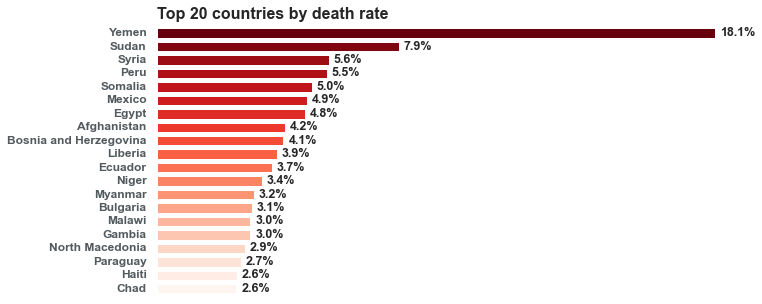

In [28]:
# List down top 20 countries in death rate
death_rate= df.groupby('country')['total_cases','total_deaths'].max()
death_rate= (death_rate.total_deaths/death_rate.total_cases).dropna().sort_values()
ax= death_rate[-20:].plot(kind='barh', color= get_color_codes('Reds',20), width=0.7)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.1%}'))
for rect, label in zip(ax.patches, ax.get_yticklabels()):
    xy= (rect.get_width()+rect.get_x()/2, rect.get_y())
    plt.annotate(xy= xy, text= '{:.1%}'.format(rect.get_width()), size= 12.5,
                weight='bold', textcoords= 'offset points', xytext= (5,2), ha='left')
    xy= (rect.get_x(), rect.get_y())
    plt.annotate(xy=xy, text= label.get_text(), textcoords= 'offset points', xytext= (-10,2), ha='right', size= 12, weight='bold', color= '#525a5e')
ax.set_axis_off()
plt.title('Top 20 countries by death rate')
plt.show()

- Yemen has the highest overall death rate of 18.2%, which means 2 out of every 10 persons who have been diagnosed with the disease, dies.
- Sudan, Peru and Syria have the highest death rate after Yemen. 
- Most of the top countries in death rate belong from Middle-east and African countries.

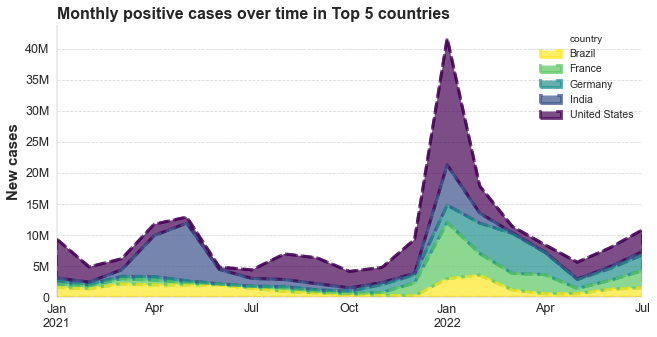

In [29]:
# Monthly trends in positive cases in top most affected countries
top_countries=  grped_countries.total_cases.sort_values()[-5:].index
grouper= pd.Grouper(key='date', freq='M')
ax=df[df.country.isin(top_countries)].groupby([grouper,'country']).new_cases.sum().unstack()\
        .plot(kind='area',color=get_color_codes('viridis_r',5), lw=3, ls='--', alpha=0.7)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_numbers))
ax.set(**{'xlabel':'', 'ylabel':'New cases', 'title': 'Monthly positive cases over time in Top 5 countries'})
plt.grid(axis='y')

In the above figure, monthly positive cases of top 5 countries have been plotted since 2021
- There are two significant peaks in positive cases since 2021. 
- India recorded 20M cases in the month of January 2022. 
- United states witnessed its highest peak in January 2022, with 42M positive cases which is around 2 times to how much recorded in India.
- We can see above, In the month of January 2022, positive cases in all the top 5 countries started increasing again simultaneously , indicating that, countries are related to each other for increase in positve cases.   

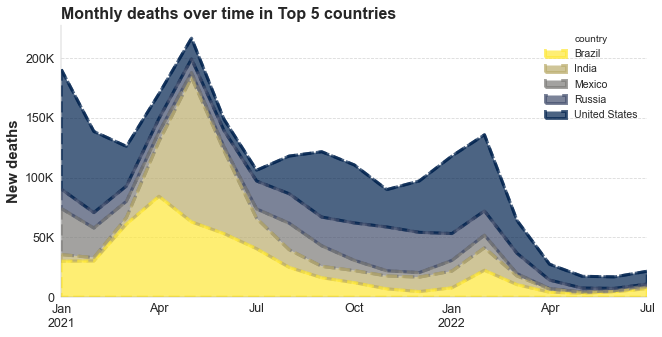

In [30]:
# Monthly trends in deaths in top most affected countries
top_countries=  grped_countries.total_deaths.sort_values()[-5:].index
grouper= pd.Grouper(key='date', freq='M')
ax=df[df.country.isin(top_countries)].groupby([grouper,'country']).new_deaths.sum().unstack()\
        .plot(kind='area', color=get_color_codes('cividis_r',5),alpha=0.7, lw=3, ls='--')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_numbers))
ax.set(**{'xlabel':'', 'ylabel':'New deaths', 'title': 'Monthly deaths over time in Top 5 countries'})
plt.grid(axis='y')

'In the above figure, monthly deaths of top 5 countries have been plotted since 2021
- There are two significant peaks in deaths since 2021. 
- In the month of April 2021, deaths in all the top 5 countries started increasing simultaneously. 

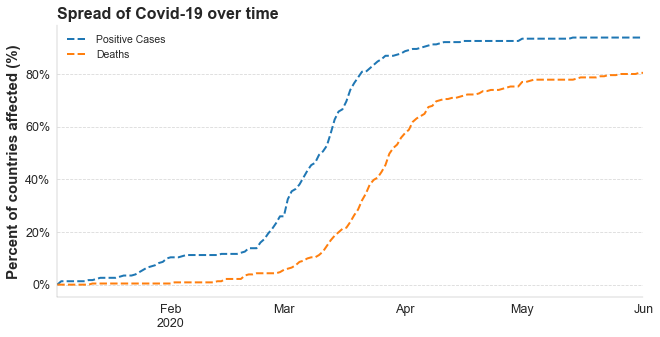

In [31]:
# How did the disease spread all over the world over time ?
ax=cases_spread_overtime.plot(ls='--', lw=2, label='Positive Cases')
deaths_spread_overtime.plot(ls='--', lw=2, label='Deaths')
plt.legend()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))
ax.set(**{'xlabel':'', 'ylabel':'Percent of countries affected (%)', 'title': 'Spread of Covid-19 over time'})
plt.grid(axis='y')

For the purpose of visualizing spread of the disease, we have got the data since the beginning of the spread.
- The very first case of the deadly disease was recorded on 29th January,2020.
- By the end of Februrary 2020, Covid-19 was spread in almost 20% percent of the world.
- By the beginning of March, 2020, it was spread in almost half of the world.
- And, by the end of April ,2020, almost 95% of the countries in world had one case of Covid-19.
- Covid-19 nearly spread all over the world, within 3 months since the onset of pandemic,

In [32]:
# List down least and most affected country in total positive cases by continents
total_cases_by_cont_and_countries= df.groupby(['continent','country']).total_cases.max().reset_index()
print('Countries with lowest and highest cases')
print(total_cases_by_cont_and_countries.set_index('country').groupby('continent')\
    .total_cases.agg(['idxmin','idxmax'])\
    .rename({'idxmin':'Lowest cases','idxmax':'Highest cases'}, axis=1))

Countries with lowest and highest cases
                        Lowest cases  Highest cases
continent                                          
Africa         Sao Tome and Principe   South Africa
Asia                           Yemen          India
Europe                        Monaco         France
North America             Montserrat  United States
Oceania                       Tuvalu      Australia
South America       Falkland Islands         Brazil


In [33]:
# List down least and most affected country in total deaths by continents
total_deaths_by_cont_and_countries= df.groupby(['continent','country']).total_deaths.max().reset_index()
print('Countries with lowest and highest deaths')
print(total_deaths_by_cont_and_countries.set_index('country').groupby('continent')\
    .total_deaths.agg(['idxmin','idxmax'])\
    .rename({'idxmin':'Lowest Deaths','idxmax':'Highest deaths'}, axis=1))

Countries with lowest and highest deaths
                           Lowest Deaths Highest deaths
continent                                              
Africa                           Burundi   South Africa
Asia                              Bhutan          India
Europe                     Faroe Islands         Russia
North America  Saint Pierre and Miquelon  United States
Oceania                 Marshall Islands      Australia
South America           Falkland Islands         Brazil


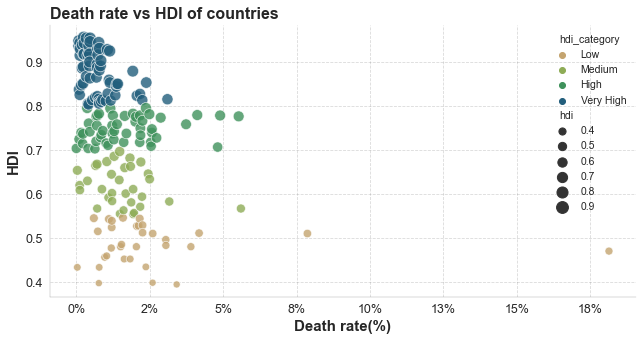

In [34]:
# Scatterplot for comparing death rate with Human development index
death_rate_by_hdi= pd.merge(death_rate.reset_index(), hdi, on='country', how='left').dropna()
death_rate_by_hdi= death_rate_by_hdi.rename({0:'death_rate'}, axis=1).set_index('country')
ax=sns.scatterplot(data= death_rate_by_hdi, x= 'death_rate', y= 'hdi', hue= 'hdi_category', size='hdi', palette='gist_earth_r', sizes= (50,150), alpha=0.8)
ax.set(**{'xlabel':'Death rate(%)', 'ylabel':'HDI', 'title': 'Death rate vs HDI of countries'})
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))
plt.grid()
plt.show()

- There is a small negative correlation between Death rate and Human Development Index of countries.
- Cases Fatality rate (Death Rate) are nearly below 3% in most of the nations, excepts some nations like Yemen where Death rate is 18%.

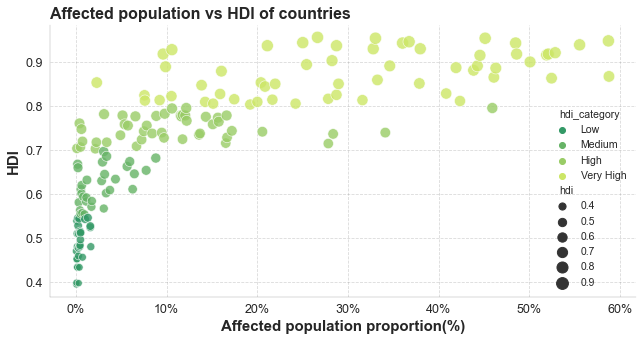

In [35]:
# Scatterplot for comparing affected population with with Human development index
pop_affected= df.groupby('country').apply(lambda x: x.total_cases.max()/x.popul.max()).sort_values().dropna().reset_index()
prop_affected_by_hdi= pd.merge(pop_affected, hdi, on='country', how='left').dropna()
prop_affected_by_hdi= prop_affected_by_hdi.rename({0:'affected_prop'}, axis=1).set_index('country')
ax=sns.scatterplot(data= prop_affected_by_hdi, x= 'affected_prop',y='hdi', hue= 'hdi_category',  size= 'hdi', palette='summer', sizes= (50,150), alpha=0.8)
ax.set(**{'xlabel':'Affected population proportion(%)', 'ylabel':'HDI', 'title': 'Affected population vs HDI of countries'})
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))
plt.grid()
plt.show()

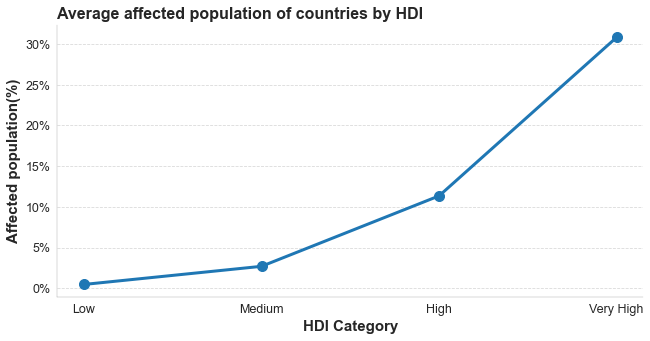

In [36]:
# Average affected proportion of population by HDI
ax= prop_affected_by_hdi.groupby('hdi_category').affected_prop.mean().sort_values().plot(marker='o', markersize=10, lw=3)
ax.set(**{'xlabel':'HDI Category', 'ylabel':'Affected population(%)', 'title': 'Average affected population of countries by HDI'})
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))
plt.grid(axis='y')
plt.show()

- There is high positive correlation between Affected population(%) vs HDI of countries.
- with increase in HDI, Affected population(%) of nations also increased.
- Affected population in Low HDI countries ranges between (0-5%), (0-10%) in Medium HDI countries, (0-35%) in High HDI countries and  so forth.

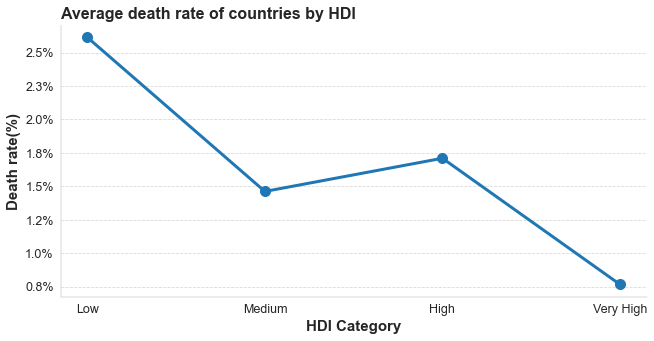

In [818]:
# Average Death rate by HDI category
ax= death_rate_by_hdi.groupby('hdi_category').death_rate.mean().sort_index().plot(marker='o', markersize=10, lw=3)
ax.set(**{'xlabel':'HDI Category', 'ylabel':'Death rate(%)', 'title': 'Average death rate of countries by HDI'})
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.1%}'))
plt.grid(axis='y')

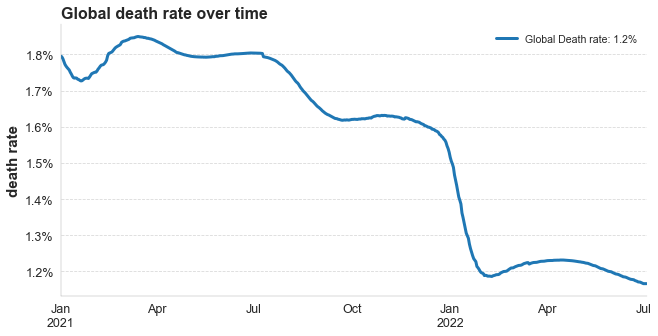

In [1016]:
# Global death rate over time
global_death_rate= df.groupby('date').apply(lambda x: x.total_deaths.max()/x.total_cases.max())
global_death_rate.plot(lw=3, label= 'Global Death rate: {:.1%}'.format(global_death_rate[-1]))
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.1%}'))
plt.gca().set(**{'xlabel':'', 'ylabel':'death rate', 'title':'Global death rate over time'})
plt.legend()
plt.grid(axis='y')
plt.show()

- There are lot of variations in global death rates over time.
- Death rate was highest in April, 2021. Since then, Death rate has been decreasing sigificantly.
- Global Death rate of 1.2% in July,2022 is recorded as the lowest since previous year. 

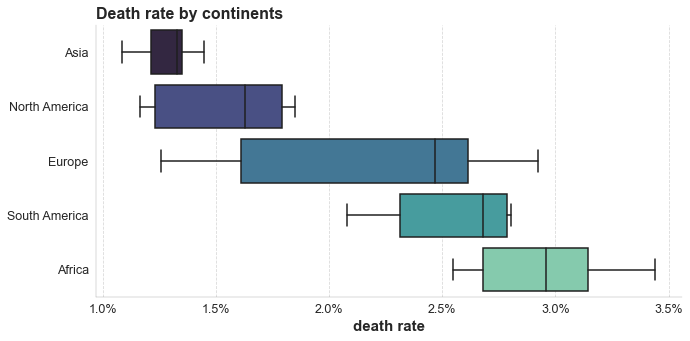

In [1143]:
# Box plot of death rate by continents
death_rates_by_continents= df1.groupby(['date','continent']).apply(lambda x: x.total_deaths.max()/x.total_cases.max()).reset_index()
sns.boxplot(x= 0, y= 'continent', data= death_rates_by_continents, orient='horizontal', palette='mako', order= ['Asia','North America','Europe','South America','Africa'])
plt.gca().set(**{'xlabel':'death rate', 'ylabel':'', 'title':'Death rate by continents'})
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.1%}'))
plt.grid(axis='x')
plt.show()

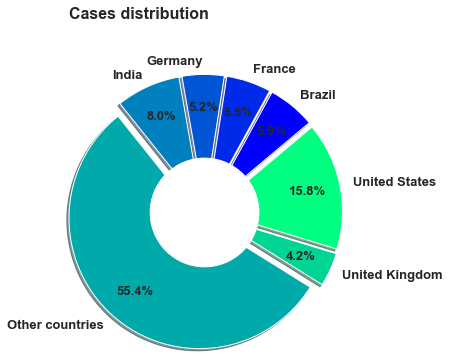

In [1144]:
# Pie chart of share of total positive cases by country
top_countries= ['India','Germany','France','Brazil','United States','United Kingdom']
pie_chart_data= (grped_countries['total_cases']/grped_countries['total_cases'].sum()).sort_values(ascending=False)
others= pie_chart_data.index[~pie_chart_data.index.isin(top_countries)]
pie_chart_data= pie_chart_data.rename(dict(zip(others, ['Other countries' for i in range(len(others))]))).groupby(level=0).sum()
ax=pie_chart_data.plot(kind='pie', explode=7*[0.07,], autopct='%.1f%%', radius=1.2, textprops= {'size':13,'weight':'bold' }, 
                        startangle=40, pctdistance= 0.75, shadow=True, colors= get_color_codes(plt.cm.winter, 7))
circle= plt.Circle(radius=0.5, xy=(0,0), fc='white')
ax.add_artist(circle)
ax.set(**{'ylabel':'','title':'Cases distribution\n\n\n'})
plt.show()

Cases in India, Germany, France, Brazil and United States, all together accounts for almost 50% of total confirmed positive cases. 